In [1]:
import torch
import torch.nn.functional as F
import torchsde
from torch.optim.lr_scheduler import LambdaLR

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt
import cfollmer.functional as functional
from cfollmer.evaluation_utils import ECE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class LeNet5(torch.nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=120),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [4]:
MNIST_train = datasets.MNIST("../data/mnist/", download=True, transform=ToTensor(), train=True)
MNIST_test = datasets.MNIST("../data/mnist/", download=True, transform=ToTensor(), train=False)

dataloader_train = DataLoader(MNIST_train, shuffle=True, batch_size=32, num_workers=2)
dataloader_test = DataLoader(MNIST_test, shuffle=False, batch_size=32, num_workers=2)
N_train = len(MNIST_train)
N_test = len(MNIST_test)

In [11]:
model = LeNet5(10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
losses = []

for i in range(10):
    for x, y in tqdm(iter(dataloader_train)):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        out = model(x)
        
        l = F.cross_entropy(out, y, reduction="mean")
        
        l.backward()
        
        losses.append(l.detach().cpu().numpy())
        
        optimizer.step()
        
losses = np.array(losses)

100%|███████████████████████████████████████████████████████████| 1875/1875 [00:02<00:00, 678.12it/s]


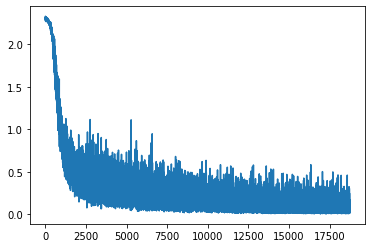

In [12]:
plt.plot(losses)

In [13]:
with torch.no_grad():
    preds = []
    confs = []
    losses = []
    
    for x, y in tqdm(iter(dataloader_test)):
        x = x.to(device)
        y = y.to(device)
        
        out = model(x)
        
        loss = F.cross_entropy(out, y, reduction="mean")
        out = torch.softmax(out, dim=1)
        
        conf, pred = torch.max(out, dim=1)
        
        preds.append(pred)
        confs.append(conf)
        losses.append(loss)
        
    losses = torch.mean(torch.stack(losses))
    preds = torch.cat(preds)
    confs = torch.cat(confs)

100%|█████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 644.00it/s]


In [14]:
torch.sum(MNIST_test.targets == preds.cpu()) / N_test

tensor(0.9758)

In [15]:
losses

tensor(0.0813, device='cuda:0')

In [16]:
ECE(confs.cpu().numpy(), preds.cpu().numpy(), MNIST_test.targets.numpy())

0.011641409161686937